<a href="https://colab.research.google.com/github/infinityrun/EIP-PHASE-1/blob/master/Prog-5/EIP_4_0_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LIBRARIES

In [1]:
import keras
from keras import *
from keras import layers
from keras.layers import Conv2D, SeparableConv2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.utils.data_utils import get_file
from keras_applications.imagenet_utils import _obtain_input_shape
from google.colab import drive
import zipfile
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Convolution2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam
from keras.optimizers import Optimizer,SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.advanced_activations import ReLU
from keras import losses
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.layers import Reshape, Lambda
from keras.activations import softmax
from keras import backend as K
from keras.models import load_model
import tensorflow as tf
# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
import os
import sys
import keras
from google.colab import files
from keras.regularizers import l2
from keras.layers.merge import add
import six
K.tensorflow_backend.set_session(tf.Session(config=config))
%tensorflow_version 1.x
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from functools import partial
from pathlib import Path 
from tqdm import tqdm
import seaborn as sns
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.callbacks import *
from keras.applications import VGG16
from IPython.display import SVG
from keras.utils import model_to_dot
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold

Using TensorFlow backend.


# RESNET ARCHITECTURE

In [0]:
def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)

def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f

def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f

def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])

def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f

def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f

def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.common.image_dim_ordering() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier

class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.common.image_dim_ordering() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(3, 3), strides=(1, 1))(input)
        
        block = conv1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        flatten = Flatten()(pool2)
        op_age = Dense(num_units['age'], activation="sigmoid", name="age_output")(flatten)
        op_bag = Dense(num_units['bag'], activation="sigmoid", name="bag_output")(flatten)
        op_emotion = Dense(num_units['emotion'], activation="sigmoid", name="emotion_output")(flatten)
        op_footwear = Dense(num_units['footwear'], activation="sigmoid", name="footwear_output")(flatten)
        op_gender = Dense(num_units['gender'], activation="softmax", name="gender_output")(flatten)
        op_image_quality = Dense(num_units['image_quality'], activation="sigmoid", name="image_quality_output")(flatten)
        op_pose = Dense(num_units['pose'], activation="sigmoid", name="pose_output")(flatten)
        op_weight = Dense(num_units['weight'], activation="sigmoid", name="weight_output")(flatten)

        output = [op_age,op_bag,op_emotion,op_footwear,op_gender,op_image_quality,op_pose,op_weight]

        model = Model(inputs=input, outputs=output)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_units):
        return ResnetBuilder.build(input_shape, num_units, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_units):
        return ResnetBuilder.build(input_shape, num_units, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_units):
        return ResnetBuilder.build(input_shape, num_units, bottleneck, [3, 4, 6, 3])

# XCEPTION ARCHITECTURE

In [0]:
def Xception():

  # Determine proper input shape
  input_shape = (224,224,3)

  img_input = Input(shape=input_shape)

  # Block 1
  x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False)(img_input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(64, (3, 3), use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  residual = Conv2D(128, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
  residual = BatchNormalization()(residual)

  # Block 2
  x = SeparableConv2D(128, (3, 3),padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)

  # Block 2 Pool
  x = MaxPooling2D((3, 3),strides=(2, 2), padding='same')(x)
  x = layers.add([x, residual])

  residual = Conv2D(256, (1, 1),strides=(2, 2), padding='same', use_bias=False)(x)
  residual = BatchNormalization()(residual)

  # Block 3
  x = Activation('relu')(x)
  x = SeparableConv2D(256, (3, 3) ,padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = SeparableConv2D(256, (3, 3),padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)

  # Block 3 Pool
  x = MaxPooling2D((3, 3),strides=(2, 2), padding='same')(x)
  x = layers.add([x, residual])

  residual = Conv2D(728, (1, 1),strides=(2, 2), padding='same', use_bias=False)(x)
  residual = BatchNormalization()(residual)

  # Block 4
  x = Activation('relu')(x)
  x = SeparableConv2D(728, (3, 3),padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = SeparableConv2D(728, (3, 3),padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)

  x = MaxPooling2D((3, 3),strides=(2, 2), padding='same')(x)
  x = layers.add([x, residual])

  # Block 5 - 12
  for i in range(8):
    residual = x
    x = Activation('relu')(x)
    x = SeparableConv2D(728, (3, 3),padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(728, (3, 3),padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(728, (3, 3) ,padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    x = layers.add([x, residual])

  residual = Conv2D(1024, (1, 1),strides=(2, 2), padding='same', use_bias=False)(x)
  residual = BatchNormalization()(residual)

  # Block 13
  x = Activation('relu')(x)
  x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)

  # Block 13 Pool
  x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
  x = layers.add([x, residual])

  # Block 14
  x = SeparableConv2D(1536, (3, 3), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # Block 14 part 2
  x = SeparableConv2D(2048, (3, 3), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  ## GAP 
  x = GlobalAveragePooling2D()(x)
  x = Dense(1000,activation='sigmoid')(x)
  x = Dense(512,activation='relu')(x)

  # heads
  op_age = Dense(num_units['age'], activation="sigmoid", name="age_output")(x)
  op_bag = Dense(num_units['bag'], activation="sigmoid", name="bag_output")(x)
  op_emotion = Dense(num_units['emotion'], activation="sigmoid", name="emotion_output")(x)
  op_footwear = Dense(num_units['footwear'], activation="sigmoid", name="footwear_output")(x)
  op_gender = Dense(num_units['gender'], activation="softmax", name="gender_output")(x)
  op_image_quality = Dense(num_units['image_quality'], activation="sigmoid", name="image_quality_output")(x)
  op_pose = Dense(num_units['pose'], activation="sigmoid", name="pose_output")(x)
  op_weight = Dense(num_units['weight'], activation="sigmoid", name="weight_output")(x)

  output = [op_age,op_bag,op_emotion,op_footwear,op_gender,op_image_quality,op_pose,op_weight]

  model = Model(img_input,output,name="xception_multilabel")
  
  return model

# LOSSES

In [0]:
losses = {
	"gender_output": "binary_crossentropy",
	"image_quality_output": "categorical_crossentropy",
	"age_output": "categorical_crossentropy",
	"weight_output": "categorical_crossentropy",
  "bag_output":"categorical_crossentropy",
  "pose_output":"categorical_crossentropy",
  "footwear_output":"categorical_crossentropy",
  "emotion_output":"categorical_crossentropy"
}
loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0,
                "weight_output": 1.0,"bag_output": 1.0,"pose_output": 1.0,"footwear_output": 1.0,
                "emotion_output": 1.0}

# CLR

In [0]:
class CyclicLR(Callback):
    
    def __init__(self, base_lr=0.001, max_lr=0.01, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [0]:
clr = CyclicLR(base_lr=0.01, max_lr=1,step_size=720.)

# ACCURACY & VALIDATION METRICS

In [0]:
acc = ["age_output_acc","bag_output_acc","emotion_output_acc","footwear_output_acc","gender_output_acc", "image_quality_output_acc","pose_output_acc", "weight_output_acc"]
val = ["val_age_output_acc","val_bag_output_acc","val_emotion_output_acc","val_footwear_output_acc","val_gender_output_acc", "val_image_quality_output_acc","val_pose_output_acc", "val_weight_output_acc"]

In [0]:
# reduce_lr_pl = ReduceLROnPlateau(factor=np.sqrt(0.01), cooldown=0, patience=5, min_lr=0.1e-6,verbose=1)
# early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1)

# ==========================================================

### CONNECTION TO GDRIVE AND LOADING DATA

In [9]:
# mount gdrive and unzip data
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [10]:
with zipfile.ZipFile('./gdrive/My Drive/canvas/hvc_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')
%ls

gdrive/  hvc_annotations.csv  resized/  sample_data/


### READ ANNOTATIONS

In [11]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
df.head()

,filename,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,images/Set1/5580_2 (3).jpg,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,images/Set1/4650_1 (4).jpg,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,images/Set1/44880_0.jpg,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,images/Set1/26130_2.jpg,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,images/Set1/IMG (4438).jpg,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [12]:
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


### ONE HOT ENCODING OF INPUT DATAFRAME

In [13]:
# one hot encoding of labels
one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


### SAMPLE IMAGES AND THEIR CORRESPONDING LABELS

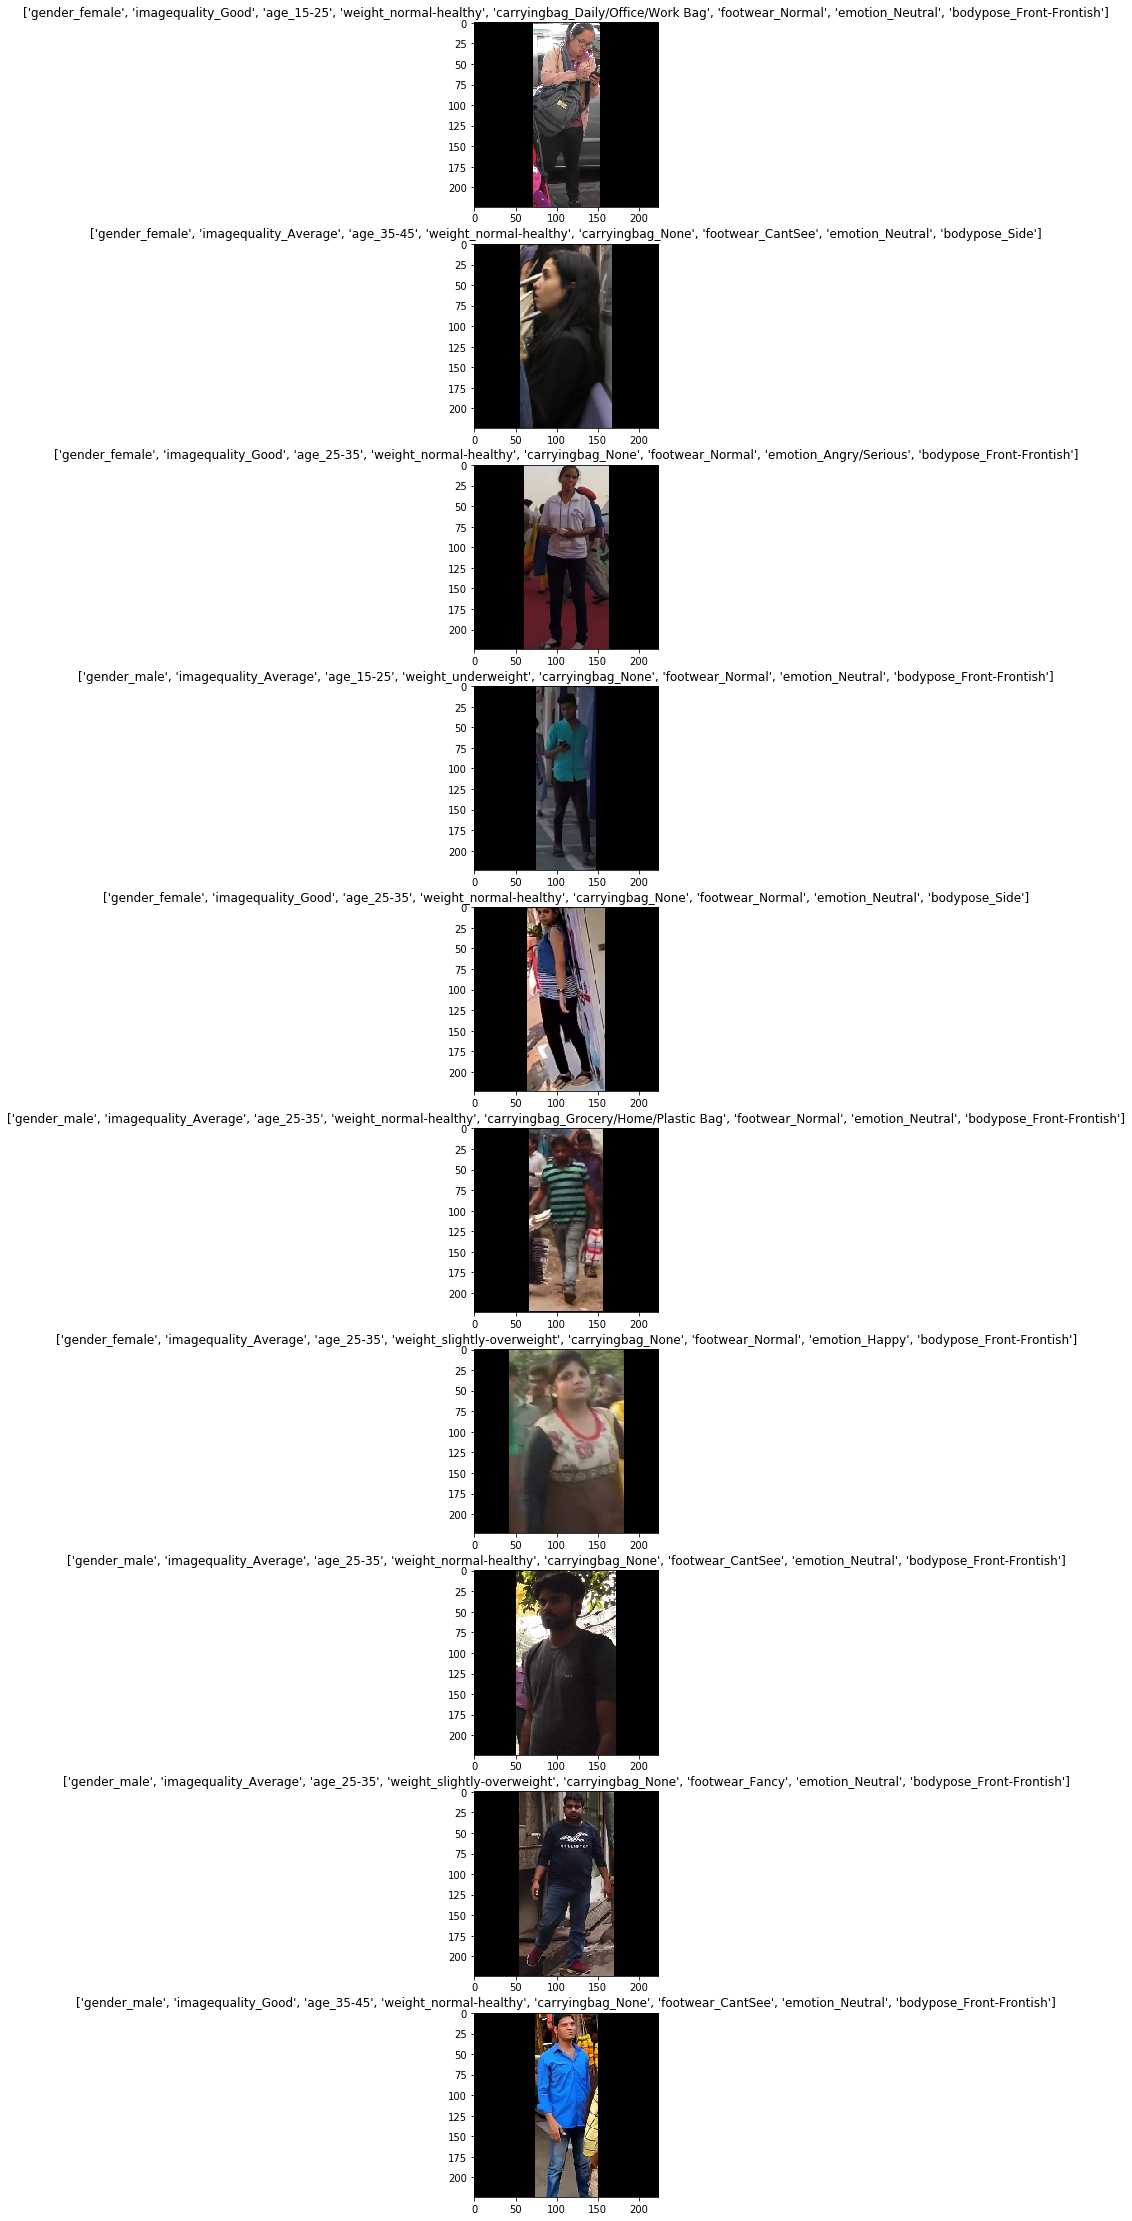

In [14]:
attr_names = one_hot_df.columns[1:]
plt.figure(figsize=(8,40))
n_row=10
n_col=1
for i in range(10):
  ran = random.randint(0,500)
  img = plt.imread('./resized/'+str(ran)+'.jpg')
  plt.subplot(n_row,n_col,i+1)
  plt.imshow(img)
  attr=[]
  attr = one_hot_df.iloc[ran-1,1:]
  d = {}
  nam=[]
  for i in range(len(attr)):
    d[i] = attr[i]
  nam = [attr_names[i] for i in d.keys() if d[i]==1]
  plt.title(nam)


### LABEL DISTRIBUTION ACCROSS DATASET

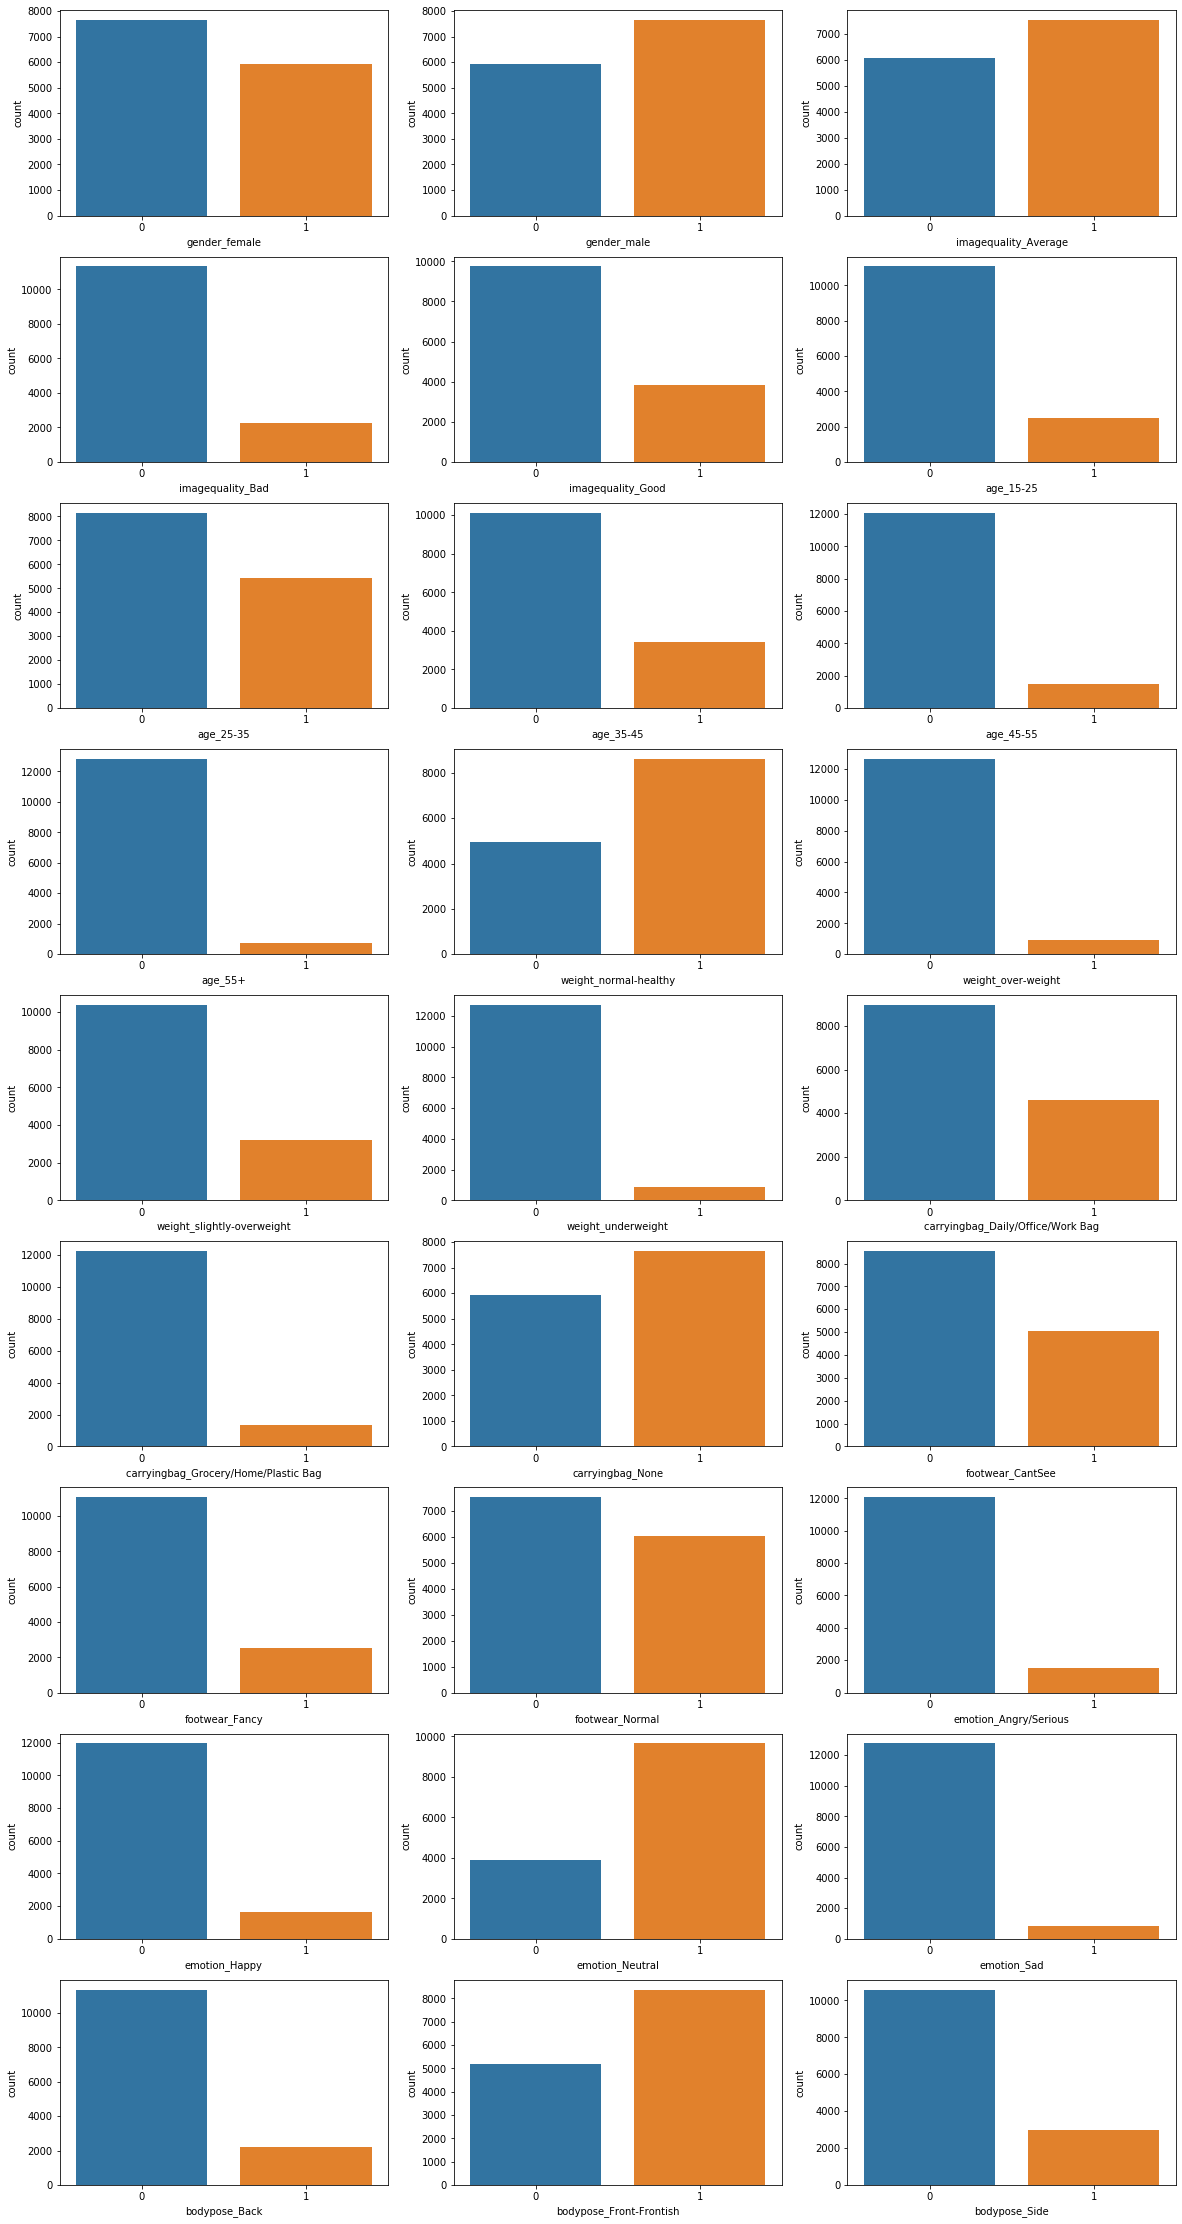

In [15]:
plt.figure(figsize=(20,40))
plt.tick_params(labelbottom=False)
n_rows = 9
n_cols = 3
for i in range(27):
  plt.subplot(n_rows,n_cols,i+1)
  sns.countplot(x=attr_names[i],data=one_hot_df)

### DATA GENERATOR HELPER FUNCTION

In [0]:
# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""
    
    def __init__(self, df, batch_size=32, shuffle=True):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


### DATA SPLIT AND OUTPUT UNITS GENERATION

In [17]:
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
print("Shape of Training DataFrame : ",train_df.shape)
print("Shape of Test DataFrame : ",val_df.shape)

Shape of Training DataFrame :  (11537, 28)
Shape of Test DataFrame :  (2036, 28)


In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32)
valid_gen = PersonDataGenerator(val_df, batch_size=32,shuffle=False)

In [19]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

# XCEPTION MODEL TRAINING

In [20]:
model = Xception()
opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
    loss_weights=loss_weights, 
    metrics=["accuracy"]
)
model.summary()













Model: "xception_multilabel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________

In [40]:
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=30,
    verbose=1
    # callbacks=callback
)

Epoch 1/30
678/678 [==============================] - 176s 259ms/step - loss: 7.8553 - age_output_loss: 1.4378 - bag_output_loss: 0.9193 - emotion_output_loss: 0.9209 - footwear_output_loss: 0.9952 - gender_output_loss: 0.7042 - image_quality_output_loss: 0.9398 - pose_output_loss: 0.9480 - weight_output_loss: 0.9901 - age_output_acc: 0.3997 - bag_output_acc: 0.5634 - emotion_output_acc: 0.7105 - footwear_output_acc: 0.5077 - gender_output_acc: 0.5418 - image_quality_output_acc: 0.5553 - pose_output_acc: 0.6093 - weight_output_acc: 0.6395 - val_loss: 7.7855 - val_age_output_loss: 1.4286 - val_bag_output_loss: 0.9331 - val_emotion_output_loss: 0.9177 - val_footwear_output_loss: 0.9913 - val_gender_output_loss: 0.6877 - val_image_quality_output_loss: 0.9252 - val_pose_output_loss: 0.8978 - val_weight_output_loss: 1.0041 - val_age_output_acc: 0.3913 - val_bag_output_acc: 0.5577 - val_emotion_output_acc: 0.7126 - val_footwear_output_acc: 0.5303 - val_gender_output_acc: 0.5507 - val_image_q

#### XCEPTION MODEL: TRAINING ACCURACY VS VALIDATION ACCURACY GRAPH

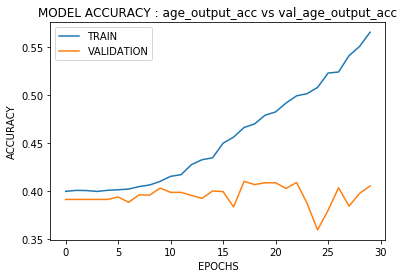

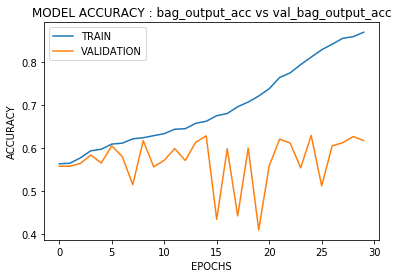

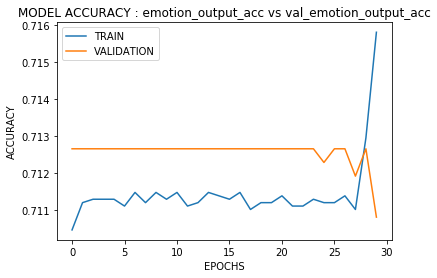

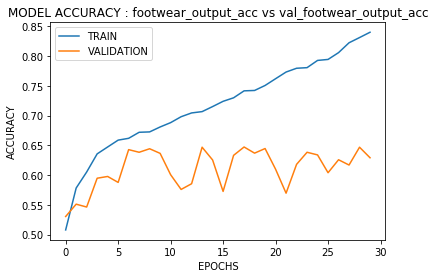

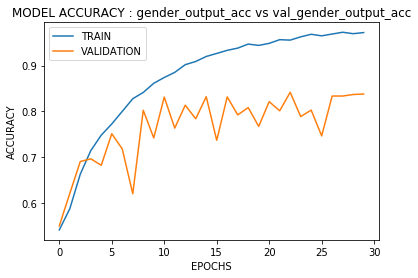

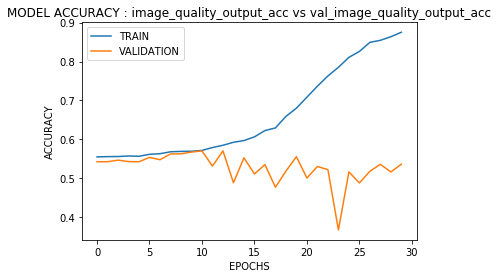

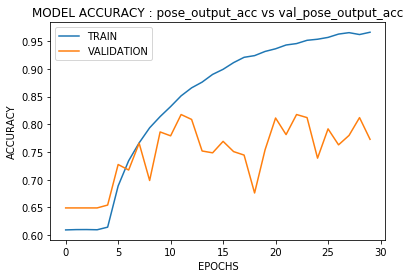

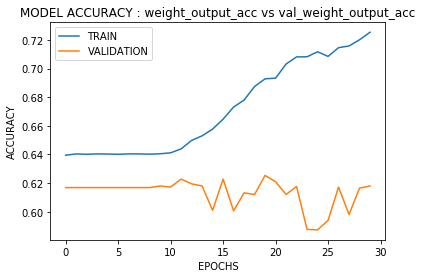

In [41]:
for i in range(8):
  plt.plot(model.history.history[acc[i]])
  plt.plot(model.history.history[val[i]])
  plt.title("MODEL ACCURACY : "+str(acc[i])+" vs "+str(val[i]))
  plt.ylabel('ACCURACY')
  plt.xlabel('EPOCHS')
  plt.legend(['TRAIN', 'VALIDATION'], loc='upper left')
  plt.show()

# RESNET-18 MODEL TRAINING 


In [42]:
model = ResnetBuilder.build_resnet_18((3, 224, 224), num_units)
opt = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
    loss_weights=loss_weights, 
    metrics=["accuracy"]
)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 224, 224, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_98 (BatchNo (None, 224, 224, 64) 256         conv2d_33[0][0]                  
__________________________________________________________________________________________________
activation_88 (Activation)      (None, 224, 224, 64) 0           batch_normalization_98[0][0]     
____________________________________________________________________________________________

In [44]:
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=30,
    verbose=1
    # callbacks=callback
)

Epoch 1/30
678/678 [==============================] - 270s 398ms/step - loss: 8.7960 - age_output_loss: 1.4399 - bag_output_loss: 0.9201 - emotion_output_loss: 0.9259 - footwear_output_loss: 1.0179 - gender_output_loss: 0.7180 - image_quality_output_loss: 0.9857 - pose_output_loss: 0.9440 - weight_output_loss: 0.9898 - age_output_acc: 0.4004 - bag_output_acc: 0.5647 - emotion_output_acc: 0.7111 - footwear_output_acc: 0.4881 - gender_output_acc: 0.5417 - image_quality_output_acc: 0.5548 - pose_output_acc: 0.6097 - weight_output_acc: 0.6399 - val_loss: 8.6231 - val_age_output_loss: 1.4442 - val_bag_output_loss: 0.9330 - val_emotion_output_loss: 0.9180 - val_footwear_output_loss: 1.0079 - val_gender_output_loss: 0.6837 - val_image_quality_output_loss: 0.9847 - val_pose_output_loss: 0.9017 - val_weight_output_loss: 1.0029 - val_age_output_acc: 0.3913 - val_bag_output_acc: 0.5577 - val_emotion_output_acc: 0.7126 - val_footwear_output_acc: 0.4822 - val_gender_output_acc: 0.5851 - val_image_q

# K-FOLD TRAINING WITH XCEPTION MODEL

In [17]:
i = 0
acc_scores_kfold = {}
kf = KFold(n_splits=5, shuffle=False)
load_saved_model = False

for x, y in kf.split(one_hot_df):
  train_df = one_hot_df.iloc[x]
  val_df = one_hot_df.iloc[y]
  # create train and validation data generators
  train_gen = PersonDataGenerator(train_df, batch_size=16)
  valid_gen = PersonDataGenerator(val_df, batch_size=16,shuffle=False)

  # get number of output units from data
  images, targets = next(iter(train_gen))
  num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
  
  if not load_saved_model:
    model = Xception()
    print("Traning from Scratch...")
  else:
    print("Loading previous weights from trained model...")
    model = Xception()
    model.load_weights('kfold_model_'+str(i-1))
    print("Loaded model weights successfully...")

  opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  
  model.compile(
      optimizer=opt,
      loss="categorical_crossentropy", 
      loss_weights=loss_weights, 
      metrics=["accuracy"]
  )


  model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=25,
    verbose=1
    # callbacks=callback
  )

  model.save_weights('kfold_model_'+str(i))
  
  val_acc = {}
  for ind,name in enumerate(val):
    val_acc[name] = max(model.history.history[val[i]])
  acc_scores_kfold[i] = val_acc
  i+=1
  load_saved_model = True











Traning from Scratch...


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/25
678/678 [==============================] - 181s 267ms/step - loss: 7.8431 - age_output_loss: 1.4371 - bag_output_loss: 0.9187 - emotion_output_loss: 0.9200 - footwear_output_loss: 0.9841 - gender_output_loss: 0.6994 - image_quality_output_loss: 0.9479 - pose_output_loss: 0.9463 - weight_output_loss: 0.9896 - age_output_acc: 0.4004 - bag_output_acc: 0.5653 - emotion_output_acc: 0.7098 - footwear_output_acc: 0.5268 - gender_output_acc: 0.5501 - image_quality_output_acc: 0.5538 - pose_output_acc: 0.6098 - weight_output_acc: 0.6396 - val_loss: 8.7766 - val_age_output_loss: 1.4741 - val_bag_output_loss: 1.0883 - val_emotion_output_loss: 1.0042 - val_footwear_output_loss: 1.5973 - val_gender_output_loss: 0.6849 - val_image_quality_output_loss: 1.0134 - val_pose_output_loss: 0.8969 - val_weight_output_loss: 1.0176 - val_age_output_acc: 0.3913 - val_bag

In [18]:
print("KFOLD Xception Accuracy :")
acc_scores_kfold

KFOLD Xception Accuracy :


{0: {'val_age_output_acc': 0.40421597633136097,
  'val_bag_output_acc': 0.40421597633136097,
  'val_emotion_output_acc': 0.40421597633136097,
  'val_footwear_output_acc': 0.40421597633136097,
  'val_gender_output_acc': 0.40421597633136097,
  'val_image_quality_output_acc': 0.40421597633136097,
  'val_pose_output_acc': 0.40421597633136097,
  'val_weight_output_acc': 0.40421597633136097},
 1: {'val_age_output_acc': 0.8258136094674556,
  'val_bag_output_acc': 0.8258136094674556,
  'val_emotion_output_acc': 0.8258136094674556,
  'val_footwear_output_acc': 0.8258136094674556,
  'val_gender_output_acc': 0.8258136094674556,
  'val_image_quality_output_acc': 0.8258136094674556,
  'val_pose_output_acc': 0.8258136094674556,
  'val_weight_output_acc': 0.8258136094674556},
 2: {'val_age_output_acc': 0.9086538461538461,
  'val_bag_output_acc': 0.9086538461538461,
  'val_emotion_output_acc': 0.9086538461538461,
  'val_footwear_output_acc': 0.9086538461538461,
  'val_gender_output_acc': 0.90865384615

# K-FOLD TRAINING WITH RESNET-18 MODEL

In [0]:
i = 0
acc_scores_kfold = {}
kf = KFold(n_splits=3, shuffle=False)
load_saved_model = False

for x, y in kf.split(one_hot_df):
  train_df = one_hot_df.iloc[x]
  val_df = one_hot_df.iloc[y]
  # create train and validation data generators
  train_gen = PersonDataGenerator(train_df, batch_size=16)
  valid_gen = PersonDataGenerator(val_df, batch_size=16,shuffle=False)

  # get number of output units from data
  images, targets = next(iter(train_gen))
  num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
  
  if not load_saved_model:
    model = ResnetBuilder.build_resnet_18((3, 224, 224), num_units)
    print("Traning from Scratch...")
  else:
    print("Loading previous weights from trained model...")
    model = ResnetBuilder.build_resnet_18((3, 224, 224), num_units)
    model.load_weights('resnet_model_'+str(i-1))
    print("Loaded model weights successfully...")

  opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  
  model.compile(
      optimizer=opt,
      loss="categorical_crossentropy", 
      loss_weights=loss_weights, 
      metrics=["accuracy"]
  )

  model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=30,
    verbose=1
    # callbacks=[clr]
  )

  model.save_weights('resnet_model_'+str(i))
  
  val_acc = {}
  for ind,name in enumerate(val):
    val_acc[name] = max(model.history.history[val[i]])
  acc_scores_kfold[i] = val_acc
  i+=1
  load_saved_model = True

In [1]:
print("KFOLD ResNet Accuracy :")
acc_scores_kfold

KFOLD ResNet Accuracy :


NameError: ignored

In [0]:
img = io.imread("https://previews.123rf.com/images/belchonock/belchonock1804/belchonock180458570/99372132-poor-man-begging-for-money-on-street.jpg")
img = cv2.resize(img, dsize=(224,224,3))
x = image.img_to_array(img)
preds =  model.predict(x)
print(preds)